In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_LPC_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 127 × 19304
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
COPs,3,6
MFOLs,5,5
MOL_A,3,3
MOL_B,5,9
MOL_C,5,8
MOL_D,5,9
MOL_E,4,9
MOL_F,3,9
MOL_G,3,3


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['MOL_B', 'MOL_E'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (27, 19304)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Pandey et al. 2022': 'Pandey'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-1-0-0-0-0-0,(this study),ctrl,MOL_B,1,ctrl_1,LPC_Saline_2,Adams,795431,13.586639,1,MOL_B_LPC_Saline_2
donor_ctrl_2_0-1-0-0-0-0-0,(this study),ctrl,MOL_B,2,ctrl_2,LPC_Saline_1,Adams,1609327,14.291327,2,MOL_B_LPC_Saline_1
donor_ctrl_3_0-1-0-0-0-0-0,Pandey et al. 2022,ctrl,MOL_B,3,ctrl_3,LPC_ctrl_3,Pandey,1443669,14.182698,3,MOL_B_LPC_ctrl_3
donor_ctrl_4_0-1-0-0-0-0-0,Pandey et al. 2022,ctrl,MOL_B,4,ctrl_4,LPC_ctrl_2,Pandey,13068125,16.385687,4,MOL_B_LPC_ctrl_2
donor_ctrl_5_0-1-0-0-0-0-0,Pandey et al. 2022,ctrl,MOL_B,5,ctrl_5,LPC_ctrl_1,Pandey,5994797,15.606402,5,MOL_B_LPC_ctrl_1


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

MOL_B_LPC_Saline_2
MOL_B_LPC_Saline_1
MOL_B_LPC_ctrl_3
MOL_B_LPC_ctrl_2
MOL_B_LPC_ctrl_1
MOL_B_LPC_7d_2
MOL_B_LPC_7d_1
MOL_B_LPC_5d_1
MOL_B_LPC_5d_3
MOL_B_LPC_28d_3
MOL_B_LPC_28d_1
MOL_B_LPC_5d_2
MOL_B_LPC_28d_2
MOL_B_LPC_5d_4
MOL_E_LPC_Saline_2
MOL_E_LPC_Saline_1
MOL_E_LPC_ctrl_2
MOL_E_LPC_ctrl_1
MOL_E_LPC_7d_2
MOL_E_LPC_7d_1
MOL_E_LPC_5d_1
MOL_E_LPC_5d_3
MOL_E_LPC_28d_3
MOL_E_LPC_28d_1
MOL_E_LPC_5d_2
MOL_E_LPC_28d_2
MOL_E_LPC_5d_4


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           ['MOL_B_LPC_ctrl_3',
                                'MOL_B_LPC_ctrl_2',
                                'MOL_B_LPC_ctrl_1',
                                'MOL_E_LPC_28d_3',
                                'MOL_E_LPC_28d_2',
                                'MOL_E_LPC_28d_1',
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (6, 19304)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
LPC_ctrl_3,Pandey et al. 2022,ctrl,MOL_B,3,ctrl_3,Pandey,1443669,14.182698,3,MOL_B_LPC_ctrl_3
LPC_ctrl_2,Pandey et al. 2022,ctrl,MOL_B,4,ctrl_4,Pandey,13068125,16.385687,4,MOL_B_LPC_ctrl_2
LPC_ctrl_1,Pandey et al. 2022,ctrl,MOL_B,5,ctrl_5,Pandey,5994797,15.606402,5,MOL_B_LPC_ctrl_1
LPC_28d_3,Pandey et al. 2022,stim,MOL_E,5,stim_5,Pandey,3715858,15.128120,5,MOL_E_LPC_28d_3
LPC_28d_1,Pandey et al. 2022,stim,MOL_E,6,stim_6,Pandey,6131415,15.628936,6,MOL_E_LPC_28d_1
LPC_28d_2,Pandey et al. 2022,stim,MOL_E,8,stim_8,Pandey,7497906,15.830134,8,MOL_E_LPC_28d_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[  0   0  57   1  12]
 [  5   3 743   9 158]
 [  4   0 206   6  50]
 [  3   1 202   6  27]
 [  5   0 464   8  56]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

           Group Reps  Batch
LPC_ctrl_3  ctrl    3 Pandey
LPC_ctrl_2  ctrl    4 Pandey
LPC_ctrl_1  ctrl    5 Pandey
LPC_28d_3   stim    5 Pandey
LPC_28d_1   stim    6 Pandey
LPC_28d_2   stim    8 Pandey


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 19304     6

ctrl stim 
   3    3 


In [16]:
%%R

cd <- x$samples$group
print(cd)

[1] ctrl ctrl ctrl stim stim stim
Levels: ctrl stim


In [17]:
%%R

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [18]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 11337     6


In [19]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 9969    6


In [20]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 6.291882 6.044937


In [21]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

[1] 1.0008559 1.0353893 0.9822590 0.9784511 1.0343739 0.9706935


In [22]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

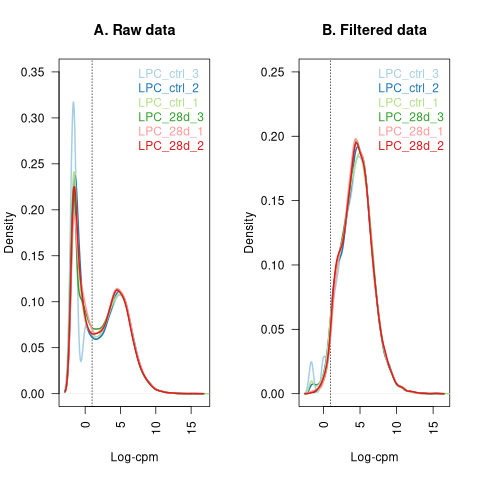

In [23]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

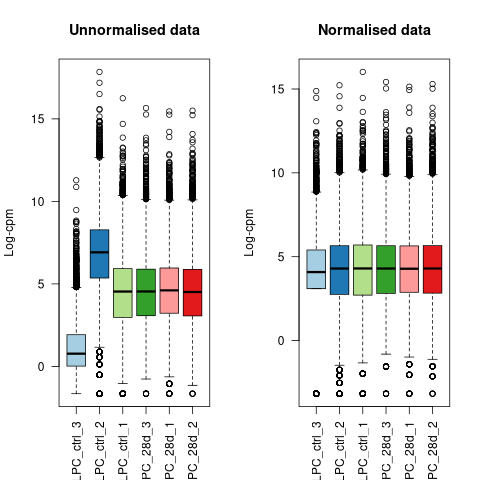

In [24]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [25]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

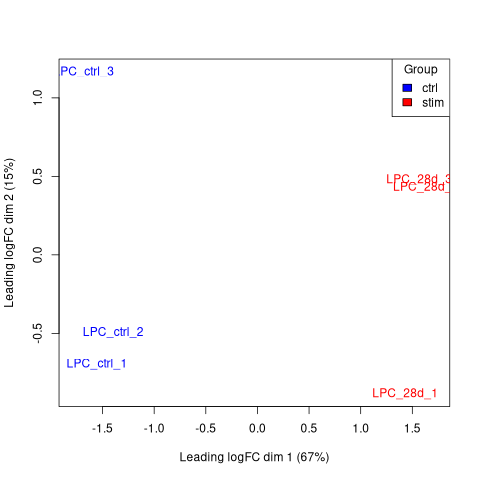

In [26]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

In [27]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [28]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [29]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

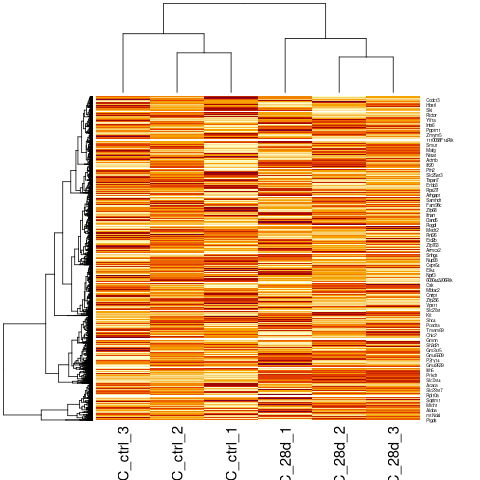

In [30]:
%%R
heatmap(logCPM)

# Lets try with voom:

In [31]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


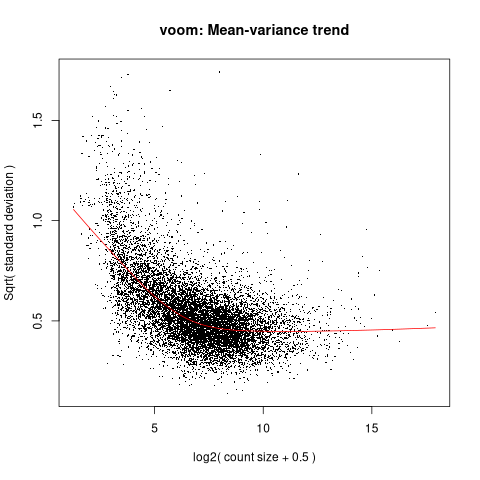

In [33]:
%%R
y <- voom(x2$counts, design, plot=TRUE)

In [34]:
%%R
fit <- lmFit(y, design)
head(coef(fit))

                cdctrl   cdstim
0610009B22Rik 5.455034 5.936873
0610009L18Rik 3.374434 3.171033
0610010F05Rik 5.358756 5.257663
0610010K14Rik 5.579706 5.915647
0610012G03Rik 5.540760 6.021257
0610030E20Rik 4.501191 4.299410


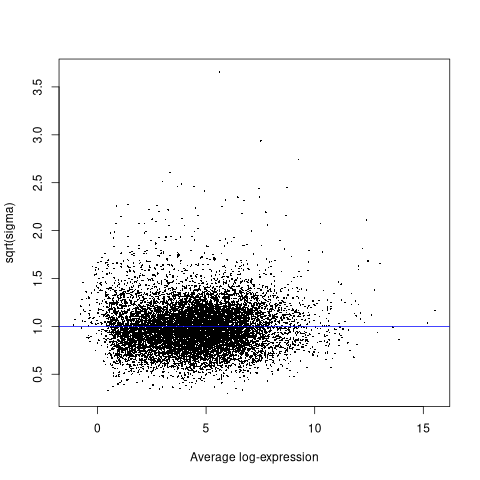

In [35]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [36]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

             logFC  AveExpr        t      P.Value    adj.P.Val        B
C4b       6.014434 7.275518 36.49204 6.369009e-14 7.220546e-10 21.42328
Serpina3n 7.949283 5.052831 25.42069 5.164239e-12 2.927349e-08 16.08063
Anxa2     6.597289 4.230177 20.19270 8.260166e-11 3.121517e-07 14.17203
Slc9a3r2  3.787360 6.653274 19.63000 1.158402e-10 3.283201e-07 14.99920
Piezo2    6.784123 4.060665 18.52956 2.306305e-10 5.229317e-07 13.25701
Cebpd     3.511025 4.929288 18.01514 3.224548e-10 6.092783e-07 13.92309
Astn2     3.752409 5.355833 17.45293 4.699402e-10 7.611018e-07 13.60701
Aldh1l2   3.726041 3.995650 15.71377 1.624835e-09 2.076235e-06 12.28656
B2m       4.490594 6.321066 15.69468 1.648242e-09 2.076235e-06 12.39674
Socs3     6.518836 4.385444 15.48615 1.928978e-09 2.186882e-06 11.88705


In [37]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1482


In [38]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 1222


In [39]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 847


In [40]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 578
             logFC  AveExpr         t      P.Value    adj.P.Val        B
Tagln2   10.151475 1.804509 13.206133 1.235118e-08 5.353704e-06 8.562907
Col6a1    9.753452 1.601484  9.906936 3.193435e-07 3.935214e-05 6.352178
Klk6      9.517332 3.195608 10.144690 2.456657e-07 3.438410e-05 6.738236
Col6a2    9.399903 1.953946  9.142184 7.689366e-07 7.145438e-05 5.687461
Tmem176a  8.847657 1.154524 13.169832 1.275029e-08 5.353704e-06 8.536268
Col13a1   8.742247 1.873852 14.594038 3.866374e-09 2.663150e-06 9.244557


In [41]:
%%R
if ('Gfap' %in% rownames(genes_up_sorted)) {
    print("Gene is in the index of genes_up_sorted")
} else {
    print("Gene is not in the index of genes_up_sorted")
}

[1] "Gene is not in the index of genes_up_sorted"


In [42]:
%%R
if ('Klk8' %in% rownames(genes_up_sorted)) {
    print("Gene is in the index of genes_up_sorted")
} else {
    print("Gene is not in the index of genes_up_sorted")
}

[1] "Gene is in the index of genes_up_sorted"


In [43]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 269
                  logFC    AveExpr         t      P.Value    adj.P.Val
Gm41609       -4.372407 -0.4184281 -6.709607 1.905722e-05 0.0006947000
Rtl5          -3.645288 -0.2743409 -3.932244 1.898499e-03 0.0201360819
Gm15594       -3.637314  0.7498018 -3.485351 4.342241e-03 0.0369579458
9330199G10Rik -3.110362  2.3464041 -8.127634 2.700454e-06 0.0001765897
Plekhh2       -3.102096  3.0415149 -7.498654 6.231941e-06 0.0003086326
Agmo          -3.098798  1.8824682 -6.205216 4.064060e-05 0.0012061320
                      B
Gm41609        2.998888
Rtl5          -1.076391
Gm15594       -1.875850
9330199G10Rik  5.093411
Plekhh2        4.266465
Agmo           2.491384


In [ ]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/LPC_remyel_MOL_BvE_voom_NEW.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Voom wqw

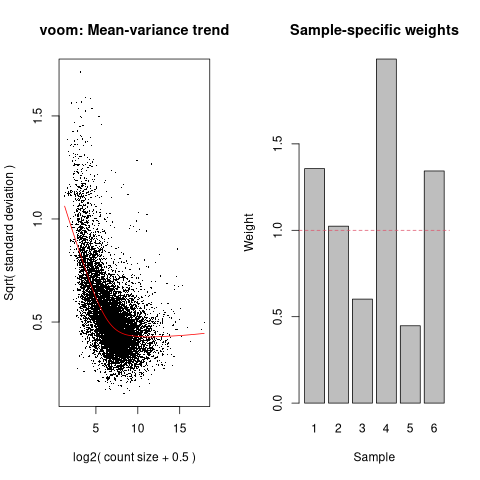

In [45]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [48]:
%%R

fit <- lmFit(y_vqw_full, design)

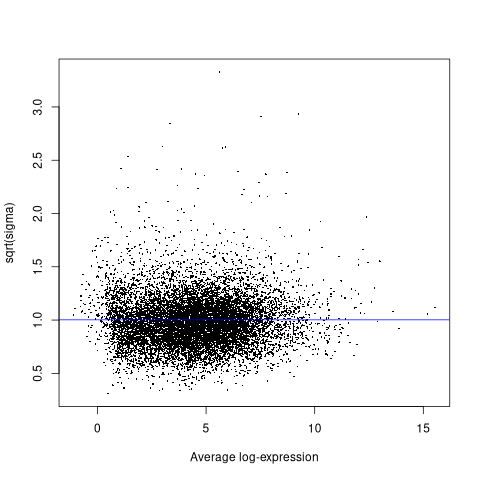

In [49]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [50]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

              logFC  AveExpr         t      P.Value    adj.P.Val        B
C4b        5.950542 7.275518  37.75992 9.039043e-16 1.024756e-11 25.40311
Serpina3n  7.867647 5.052831  24.69132 3.671651e-13 2.081275e-09 18.31709
Anxa2      6.543960 4.230177  20.60690 4.599083e-12 1.564695e-08 16.65643
Slc9a3r2   3.659691 6.653274  20.33799 5.520668e-12 1.564695e-08 17.89199
Cebpd      3.533207 4.929288  17.91646 3.190794e-11 6.688340e-08 16.07010
B2m        4.228047 6.321066  17.78193 3.539741e-11 6.688340e-08 16.06318
Piezo2     6.832412 4.060665  17.31840 5.089875e-11 8.043045e-08 14.52783
Astn2      3.738622 5.355833  17.18156 5.675607e-11 8.043045e-08 15.58681
Ankub1    -2.467775 5.818469 -16.08909 1.394641e-10 1.756782e-07 14.72297
H2-D1      4.855287 7.556454  15.84857 1.712536e-10 1.941502e-07 14.51861


In [51]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1934


In [54]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 800
            logFC  AveExpr         t      P.Value    adj.P.Val         B
Tagln2   9.972248 1.804509 12.748950 3.198728e-09 1.049877e-06  9.540623
Klk6     9.696035 3.195608 12.070527 6.583557e-09 1.554954e-06  9.441076
Col6a1   9.495725 1.601484  8.442442 6.087417e-07 4.233929e-05  5.821182
Col6a2   8.938433 1.953946  7.744866 1.701847e-06 8.613319e-05  5.008482
Tmem176a 8.592871 1.154524 12.360231 4.817581e-09 1.253359e-06  9.274928
Col13a1  8.494263 1.873852 14.100551 8.329831e-10 4.924026e-07 10.425408


In [55]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 579
                  logFC     AveExpr         t      P.Value    adj.P.Val
Gm15594       -4.245825  0.74980176 -5.085504 1.538491e-04 2.527808e-03
Gm41609       -4.167787 -0.41842810 -6.889891 6.523807e-06 2.357231e-04
Nedd9         -3.574302 -0.02265549 -5.349037 9.432839e-05 1.753116e-03
Gm12145       -3.500002  0.61601812 -5.647251 5.483550e-05 1.151241e-03
9330199G10Rik -3.339013  2.34640406 -8.549078 5.228794e-07 3.778687e-05
Nucb2         -3.292017 -0.06686419 -4.838250 2.454233e-04 3.549372e-03
                      B
Gm15594       1.1556083
Gm41609       3.9336767
Nedd9         1.5838379
Gm12145       2.0953370
9330199G10Rik 6.5515617
Nucb2         0.7277737


# If output --> change name!

In [56]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/LPC_remyel_MOL_BvE_voom_wqw.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Check LR Pair Overlap

In [57]:
import liana as li
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [58]:
DEG_all = pd.read_csv('./files/LPC_remyel_MOL_BvE_voom_wqw.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(11337, 7)

In [59]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(942, 7)

In [60]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 32


,ligand,receptor,logFC_ligand,logFC_receptor
6,Col6a1,Sdc1,9.495725,2.636467
5,Col6a1,Cd44,9.495725,2.928055
7,Col6a2,Cd44,8.938433,2.928055
8,Col6a2,Sdc1,8.938433,2.636467
25,Vim,Cd44,7.086521,2.928055
31,C4b,Cd46,5.950542,-1.011224
11,Tnxb,Sdc1,5.186609,2.636467
1,Sema5a,Plxna1,2.515022,2.277082
30,Sparc,Fgfr1,2.191911,1.646916
26,Apoa1,Abca1,1.904137,1.635903


In [61]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(624, 7)

In [62]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 17


,ligand,receptor,logFC_ligand,logFC_receptor
2,Col6a1,Cd44,9.495725,2.928055
3,Col6a1,Sdc1,9.495725,2.636467
4,Col6a2,Cd44,8.938433,2.928055
5,Col6a2,Sdc1,8.938433,2.636467
13,Vim,Cd44,7.086521,2.928055
6,Tnxb,Sdc1,5.186609,2.636467
1,Sema5a,Plxna1,2.515022,2.277082
16,Sparc,Fgfr1,2.191911,1.646916
14,Apoa1,Abca1,1.904137,1.635903
15,Apoe,Abca1,1.546508,1.635903


In [ ]:
#sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_LPC_remyel_MOL_BvE.csv', sep='\t', index=False)